In [2]:

from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import ssapp.Utils as Utils
import seaborn as sns

from torch.utils.data.dataloader import DataLoader
import torch

import ssapp.data.AntennaDatasetLoaders as AntennaDatasets
from ssapp.models.NeuralNetworkModels.Autoencoders import PatchAntenna1ConvAutoEncoder
from ssapp.models.HelperFunctions import loadModel

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

AntennaDatasets.set_global_random_seed(42)

dataset = AntennaDatasets.load_serialized_dataset('CircularHornDataset1')




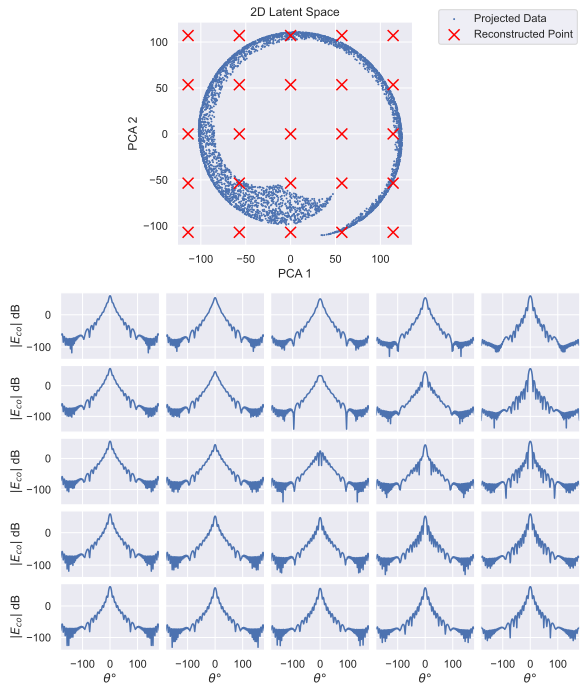

In [12]:
from ssapp.visualization import PCA_Visualisation

from ssapp.visualization.PCA_Visualisation import plotInverseTransformStandardPCA


plotInverseTransformStandardPCA(dataset,component='co',pca_components = [1,2],phi_cut = [0], num_std_dev=1.5,num_cols=5,num_rows=5)

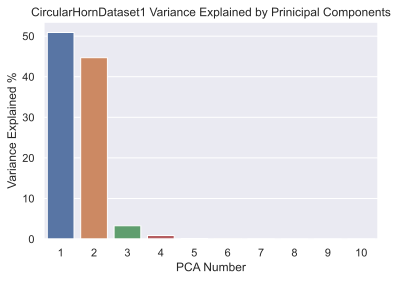

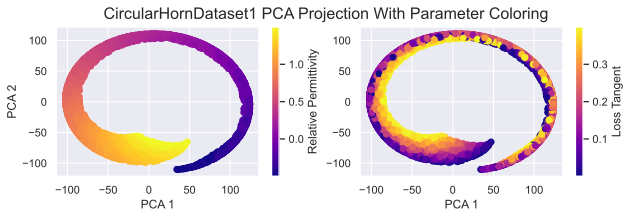

In [6]:
from ssapp.visualization.PCA_Visualisation import plotParameterColoredLatentSpace, plotPCAVariance
from ssapp.Utils import genModelComparison
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA



plotPCAVariance(dataset)


plotParameterColoredLatentSpace(dataset,pca_components = (1,2),param_names = ['Relative Permittivity','Loss Tangent'],figsize = (10,2.75))



In [13]:
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge,SGDRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import LinearSVR
from ssapp.data.Metrics import relRMSE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.neural_network import MLPRegressor


benchmark_models = {'Gaus. Proc.':GaussianProcessRegressor(),
                    'std_GP': Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor())]),
                    'Linear Reg.':LinearRegression()}

test_metrics = {'Mean Squared':metrics.mean_squared_error,
                'Max Error': metrics.max_error,
                'Explained Variance': metrics.explained_variance_score,
                'Relative RMSE ': relRMSE}



df = genModelComparison(dataset, benchmark_models= benchmark_models, test_metrics=test_metrics, train_test_ratio=0.7)

In [15]:
pd.options.display.float_format = '{:,.3e}'.format
print(df)

                    Gaus. Proc. Train  Gaus. Proc. Val  std_GP Train  \
Mean Squared                1.004e-04        8.840e-05     4.027e-05   
Max Error                   5.052e-01        4.637e-01     4.541e-01   
Explained Variance          1.000e+00        1.000e+00     1.000e+00   
Realtive RMSE               6.055e-03        5.674e-03     3.836e-03   

                    std_GP Val  Linear Reg. Train  Linear Reg. Val  
Mean Squared         3.981e-05          1.800e+00        1.794e+00  
Max Error            3.770e-01          3.076e+01        3.018e+01  
Explained Variance   1.000e+00          3.424e-01        3.466e-01  
Realtive RMSE        3.808e-03          1.386e+00        1.378e+00  


TypeError: save() missing 1 required positional argument: 'filename'

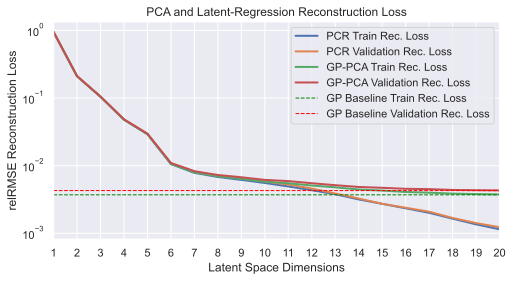

In [18]:
from ssapp.visualization.PCA_Visualisation import plotGPvsPCADimensions
from ssapp.Utils import FigureSaver

figsaver = FigureSaver(subfolder='Circular Horn')

plotGPvsPCADimensions(dataset,max_number_pca = 20)




In [19]:
figsaver.save(filename='PCA_Latent_Regression_Reconstruction_loss')

<Figure size 432x288 with 0 Axes>

In [3]:
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset
patch_dataset = load_serialized_dataset('PatchAntennaDataset2')

patchSaver = FigureSaver(subfolder='Patch Antenna Latent Space Regression')

plotGPvsPCADimensions(patch_dataset,max_number_pca = 20)


patchSaver.save(filename='PatchAntennaPCALatentReconstruction')


NameError: name 'FigureSaver' is not defined

In [32]:
from ssapp.visualization.PCA_Visualisation import plotFieldComparison
from ssapp.Utils import train_test_data_split
from ssapp.models.GPModels import PCA_GP_Model

pca_gp = PCA_GP_Model(num_components=6)

train_dataset,test_dataset = train_test_data_split(dataset=dataset)


train_loader = DataLoader(train_dataset, batch_size = len(train_dataset))
test_loader = DataLoader(test_dataset, batch_size = len(test_dataset))


train_param, train_field = next(iter(train_loader))
test_param,test_field = next(iter(test_loader))

pca_gp.fit(train_param,train_field)
pred = pca_gp.predict(test_param)






0.010777727696380664

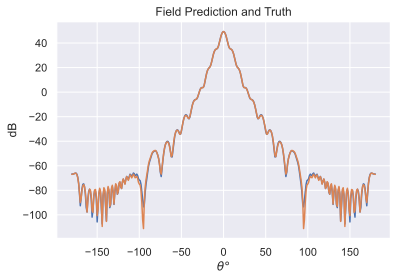

In [36]:

plotFieldComparison(test_field,pred,idx = 900,phis = 0)

pca_gp.score(test_param,test_field)
